In [27]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import thinkplot
from thinkstats2 import Cdf
from thinkstats2 import RandomSeed

from matplotlib import rc
rc('animation', html='html5')

from Cell2D import Cell2D, Cell2DViewer
import random

In [41]:
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.

    n: int number of rows
    m: int number of cols

    returns: NumPy array
    """
    left = np.repeat(np.arange(m), n)
    right = np.tile(np.arange(n), m)
    return np.transpose([left, right])

class City(Cell2D):
    """Represents a city where agents live."""

    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params

        # track variables
        self.agent_count_seq = []

        self.city_center = n//2
        dist_arr = np.fromfunction(self.distance,(n,n))

        #normalize so city center is in the middle of the array
        dist_arr = np.amax(dist_arr) - dist_arr
        self.array = dist_arr/np.amax(dist_arr)

        # make the agents
        self.make_agents()

    def distance(self, x, y):
        """Helper function for initializing each cell in the array with
        a distance from the city center.
        """
        x_dist = abs(x-self.city_center)
        y_dist = abs(y-self.city_center)
        return np.sqrt(x_dist**2 + y_dist**2)

    def make_agents(self):
        """Makes the agents."""

        # generate locations for the agents
        # TODO: change this so it's not random
        locs = make_locs(self.n, self.n)
        np.random.shuffle(locs)

        # make the agents
        num_agents = self.params.get('num_agents', 10)
        self.agents = [Agent(locs[i], self.params)
                       for i in range(num_agents)]

        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)

    def step(self):
        """Executes one time step."""
        replace = self.params.get('replace', False)

        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)
            # execute one step
            agent.step(self)
            # otherwise mark its cell occupied
            self.occupied.add(agent.loc)

        # update the time series
        self.agent_count_seq.append(len(self.agents))
        return len(self.agents)

    def add_agent(self):
        """Generates a new random agent.

        returns: new Agent
        """
        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent

    def random_loc(self):
        """Choose a random unoccupied cell.

        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc


class CityViewer(Cell2DViewer):
    """Generates visualization and animation of Sugarscape."""

    cmap = plt.get_cmap('YlOrRd')

    options = dict(interpolation='none', alpha=0.8,
                   vmin=0, vmax=9)

    def draw(self, grid=False):
        """Draws the array and any other elements.

        grid: boolean, whether to draw grid lines
        """
        self.draw_array(self.viewee.array, origin='lower')
        self.draw_agents()

    def draw_agents(self):
        """Plots the agents.
        """
        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]

    def animate_func(self, i):
        """Draws one frame of the animation."""
        Cell2DViewer.animate_func(self, i)
        xs, ys = self.get_coords()
        self.points.set_data(np.array([xs, ys]))
        return self.im, self.points

    def get_coords(self):
        """Gets the coordinates of the agents.

        Transforms from (row, col) to (x, y).

        returns: tuple of sequences, (xs, ys)
        """
        agents = self.viewee.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys


In [42]:
class Agent:
    def __init__(self, loc, params):
        """Creates a new agent at the given location.
        
        loc: tuple coordinates where in the grid is the agent located
        params: dictionary of parameters

        Modified from the agent class in ThinkComplexity2 Chapter 9.
        """
        self.loc = tuple(loc)
        self.neighbors = []
        for i in range(self.loc[0] - 1, self.loc[0] + 2):
            for j in range(self.loc[1] - 1, self.loc[1] + 2):
                if (i, j) != self.loc:
                    self.neighbors.append((i, j))

        # extract the parameters
        health_status = params.get('health_status', 2)
        # Healthy = 2, Empty cell = 0 Contagious = 1, Sick = 0.01
        

        # How resistent to disease is this agent?
        min_immunity = params.get('min_immunity', 0.5)
        max_immunity = params.get('max_immunity', 0.8)
        

        # How extroverted is this agent. Does it like to be close to 
        # other agents/the city center?
        urbanness = params.get('urbanness', 0.5)
        
        # choose attributes
        self.health_status = health_status
        self.immunity = np.random.uniform(min_immunity, max_immunity)
        self.urbanness = urbanness

    def step(self, array):
        """ Change health status/other attributes based on environment
        
        array: array representing the city and environment
        """
        
        # If sick random chance of getting better 
        if self.health_status == .01:
            # Average sickness duration of ~4 days before being cured (96 timesteps in 4 days)
            if random.randrange(0, 100) == 1:
                self.health_status = 2

            
        # If contagious decrease health status each step until in sick range
        elif self.health_status < 2:
            self.health_status -= .01
            
        # If healthy:# If contagious decrease health status each step until in sick range
        # If contagious neighbor
        # frac__neighbors_contagious
        # if random integer between (100*frac_neighbors_contagious, 101) > 100* immunity
        # become contagoious
        # else no change
        elif self.health_status >= 2:
            contagious_neighbors = 0
#             for neighbor in self.neighbors:
#                 if array.array[neighbor] < 2:
#                     contagious_neighbors += 1
#             if random.randrange(100*(contagious_neighbors/8), 101) > 100 * self.immunity:
#                self.health_status = 1
            
        return None
     

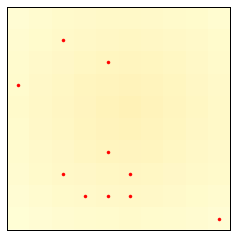

In [45]:
city = City(n=10)
viewer = CityViewer(city)
anim = viewer.animate(frames=30)

In [46]:
anim